In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import interpolation
from statsmodels.stats.anova import AnovaRM
import time
import sys
import math
import pylab as py
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import scipy.stats as sci 
import seaborn as sns
import statannot
import json
from scipy import signal

## Stats stuff
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set_style(style='whitegrid')

##### Color theme of all seaborn plot should be:

In [2]:
allPalettes = "mako"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pathToPickle = "G:/Diar SSD/Projects/GitHub/SubEscape/SubEscape_Data_Analysis/"
# pathToPickle = "/Volumes/Extreme SSD/Diar SSD/Projects/GitHub/SubEscape/SubEscape_Data_Analysis/"

In [5]:
metrics = []

metrics.append(pd.read_pickle("1648795454.0Sub_metrics_1.pkl"))
metrics.append(pd.read_pickle("1648795454.0Sub_metrics_2.pkl"))
metrics.append(pd.read_pickle("1648795454.0Sub_metrics_3.pkl"))

print('Shape of metrics: ', np.shape(metrics))

Shape of metrics:  (3,)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [6]:
metrics[0] = metrics[0].reset_index()
metrics[1] = metrics[1].reset_index()
metrics[2] = metrics[2].reset_index()

In [7]:
metrics[2]

,index,PtxID,Group,Trial,Slope,Intercept,MeanSqErr
0,0,gM483721559mr614,Reward,0,0.306694,10.482380,3302.959332
1,1,gM483721559mr614,Reward,1,0.588618,16.882820,2744.777015
2,2,gM483721559mr614,Reward,2,NaN,NaN,NaN
3,3,gM483721559mr614,Reward,3,NaN,NaN,NaN
4,4,gM483721559mr614,Reward,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1002,48,wQ432254460Cm818,NoReward,48,1.227094,-9.623789,529.645258
1003,49,wQ432254460Cm818,NoReward,49,1.496143,30.643030,1707.497633
1004,50,wQ432254460Cm818,NoReward,50,0.979288,23.544013,1081.003717
1005,51,wQ432254460Cm818,NoReward,51,1.845224,13.613174,1910.148941


In [8]:
df_metrics = metrics[0]
df_metrics = pd.concat((df_metrics, metrics[1]))
df_metrics = pd.concat((df_metrics, metrics[2]))

In [9]:
df_metrics = df_metrics.reset_index()

### Add phases based on trial numbers

In [10]:
baselineMask = (df_metrics["Trial"] < 15)
adaptationMask = (df_metrics["Trial"] > 15) & (df_metrics["Trial"] < 40)
washoutMask = (df_metrics["Trial"] > 40)

df_metrics.insert(3, "Phase", "Baseline")
df_metrics.iloc[adaptationMask,3] = "Adaptation"
df_metrics.iloc[washoutMask,3] = "Washout"
print(pd.unique(df_metrics["Phase"]))

['Baseline' 'Adaptation' 'Washout']


In [11]:
path2figure = "G:/Diar SSD/Projects/GitHub/SubEscape/SubEscape_Data_Analysis/Figure/"

<Figure size 432x288 with 0 Axes>

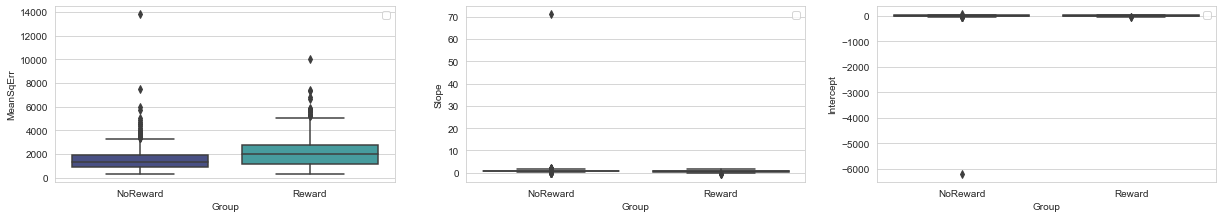

In [12]:
plt.figure()
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='MeanSqErr', palette=allPalettes, data=df_metrics)
plt.legend("")

plt.subplot(132)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='Slope', palette=allPalettes, data=df_metrics)
plt.legend("")

plt.subplot(133)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='Intercept', palette=allPalettes, data=df_metrics)
plt.legend("")

plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_BoxPlots" + "_.png", dpi = 600, bbox_inches='tight')

#### Show data for each participant before showing averages to identify outliers and to take them out

In [28]:
df_metrics

,level_0,index,PtxID,Phase,Group,Trial,Slope,Intercept,MeanSqErr,MeanSqErrAvr
2,2,2,vn265606624Yv403,Baseline,NoReward,2,0.958005,15.201928,1441.336516,15.241735
3,3,3,vn265606624Yv403,Baseline,NoReward,3,1.201034,20.377978,799.722808,17.563853
4,4,4,vn265606624Yv403,Baseline,NoReward,4,1.041973,20.057982,800.458327,18.545962
5,5,5,vn265606624Yv403,Baseline,NoReward,5,1.173514,23.896629,781.994155,21.444196
6,6,6,vn265606624Yv403,Baseline,NoReward,6,1.198141,7.551841,765.492053,17.168817
...,...,...,...,...,...,...,...,...,...,...
2076,1002,48,wQ432254460Cm818,Washout,NoReward,48,1.227094,-9.623789,529.645258,16.455854
2077,1003,49,wQ432254460Cm818,Washout,NoReward,49,1.496143,30.643030,1707.497633,18.154045
2078,1004,50,wQ432254460Cm818,Washout,NoReward,50,0.979288,23.544013,1081.003717,14.854418
2079,1005,51,wQ432254460Cm818,Washout,NoReward,51,1.845224,13.613174,1910.148941,22.600072


C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/3121585591.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=2)
C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/3121585591.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=2)


<Figure size 432x288 with 0 Axes>

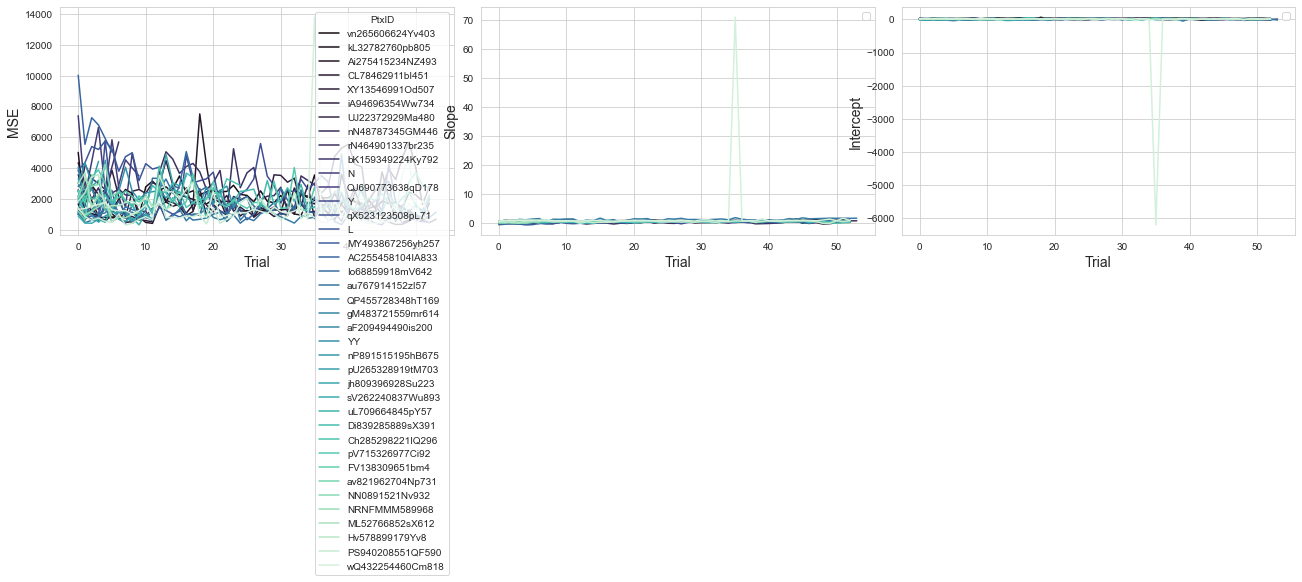

In [13]:
plt.figure()
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="MeanSqErr", hue="PtxID", palette=allPalettes, data=df_metrics)
# plt.legend(["Reward"])
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("MSE", fontsize = 14)

plt.subplot(132)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="Slope", hue="PtxID", palette=allPalettes, data=df_metrics)
plt.legend("")
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("Slope", fontsize = 14)
# plt.ylim([0,1.5])

plt.subplot(133)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="Intercept", hue="PtxID", palette=allPalettes, data=df_metrics)
plt.legend("")
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("Intercept", fontsize = 14)
# plt.ylim([-15,30])

# plt.xticks(xTickText[0],xTickText[1],rotation=45)
# plt.ylabel('TargetPL', fontsize = axisFS)

plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_MSE" + "_.png", dpi = 600, bbox_inches='tight')

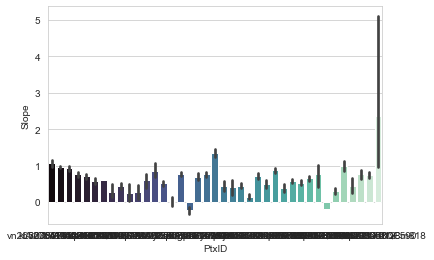

In [14]:
plt.figure()
sns.barplot(x="PtxID", y="Slope", palette=allPalettes, data=df_metrics)
plt.savefig(path2figure + str(np.round(time.time())) +"_Ptx_Outlier_Identification" + "_.png", dpi = 600, bbox_inches='tight')

In [15]:
print(pd.unique(df_metrics["PtxID"]))

['vn265606624Yv403' 'kL32782760pb805' 'Ai275415234NZ493' 'CL78462911bI451'
 'XY13546991Od507' 'iA94696354Ww734' 'UJ22372929Ma480' 'nN48787345GM446'
 'rN464901337br235' 'bK159349224Ky792' 'N' 'QJ690773638qD178' 'Y'
 'qX523123508pL71' 'L' 'MY493867256yh257' 'AC255458104IA833'
 'Io68859918mV642' 'au767914152zI57' 'QP455728348hT169' 'gM483721559mr614'
 'aF209494490is200' 'YY' 'nP891515195hB675' 'pU265328919tM703'
 'jh809396928Su223' 'sV262240837Wu893' 'uL709664845pY57'
 'Di839285889sX391' 'Ch285298221IQ296' 'pV715326977Ci92' 'FV138309651bm4'
 'av821962704Np731' 'NN0891521Nv932' 'NRNFMMM589968' 'ML52766852sX612'
 'Hv578899179Yv8' 'PS940208551QF590' 'wQ432254460Cm818']


In [16]:
## Take out outlier(s)
outlier_mask = (df_metrics["PtxID"] != "wQ432254460Cm818")

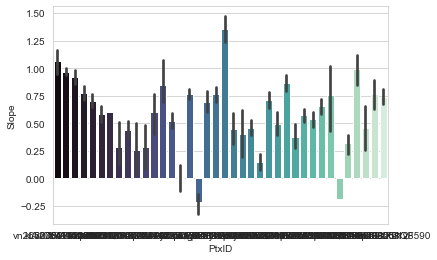

In [17]:
plt.figure()
sns.barplot(x="PtxID", y="Slope", palette=allPalettes, data=df_metrics[outlier_mask])
plt.savefig(path2figure + str(np.round(time.time())) +"_Ptx_Outlier_Identification" + "_.png", dpi = 600, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

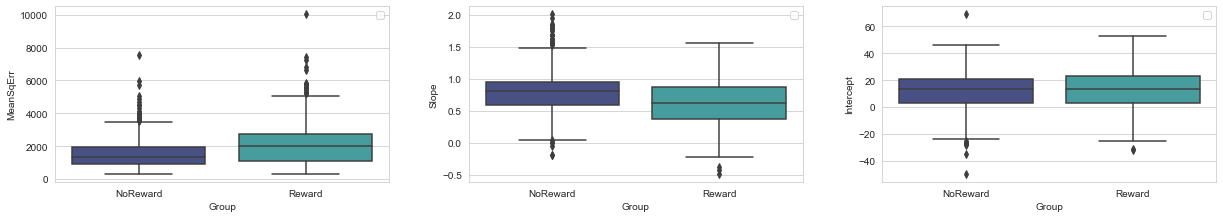

In [18]:
plt.figure()
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='MeanSqErr', palette=allPalettes, data=df_metrics[outlier_mask])
plt.legend("")

plt.subplot(132)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='Slope', palette=allPalettes, data=df_metrics[outlier_mask])
plt.legend("")

plt.subplot(133)
plt.tight_layout(pad=4)
sns.boxplot(x='Group', y='Intercept', palette=allPalettes, data=df_metrics[outlier_mask])
plt.legend("")

plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_BoxPlots" + "_.png", dpi = 600, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

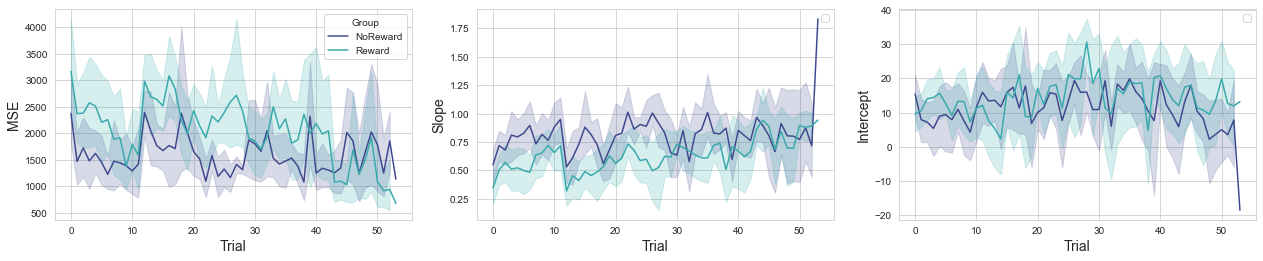

In [19]:
plt.figure()
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="MeanSqErr", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
# plt.legend(["Reward"])
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("MSE", fontsize = 14)

plt.subplot(132)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="Slope", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
plt.legend("")
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("Slope", fontsize = 14)
# plt.ylim([0,1.5])

plt.subplot(133)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="Intercept", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
plt.legend("")
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("Intercept", fontsize = 14)
# plt.ylim([-15,30])

# plt.xticks(xTickText[0],xTickText[1],rotation=45)
# plt.ylabel('TargetPL', fontsize = axisFS)

plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_MSE" + "_.png", dpi = 600, bbox_inches='tight')

### Rollowing average for the metrics to reduce noice

In [20]:
df_metrics.head(2)

,level_0,index,PtxID,Phase,Group,Trial,Slope,Intercept,MeanSqErr
0,0,0,vn265606624Yv403,Baseline,NoReward,0,0.767016,13.411624,1668.841801
1,1,1,vn265606624Yv403,Baseline,NoReward,1,1.118196,17.111654,636.585962


In [21]:
df_metrics['MeanSqErrAvr'] = df_metrics.iloc[:,7].rolling(window=3).mean()

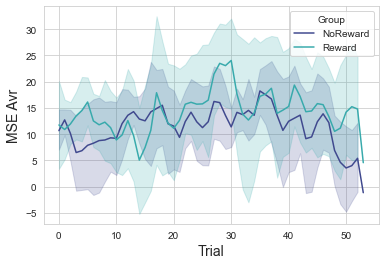

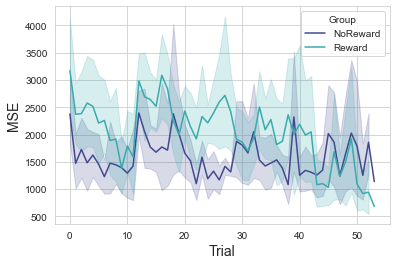

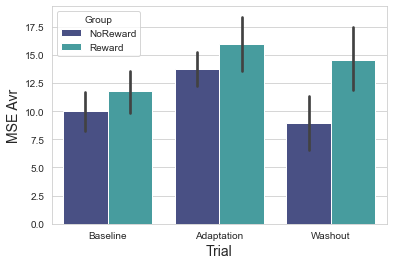

In [22]:
plt.figure(1)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="MeanSqErrAvr", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
# plt.legend(["Reward"])
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("MSE Avr", fontsize = 14)

plt.figure(2)
plt.tight_layout(pad=2)
sns.lineplot(x="Trial",y="MeanSqErr", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
# plt.legend(["Reward"])
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("MSE", fontsize = 14)

plt.figure(3)
plt.tight_layout(pad=2)
sns.barplot(x="Phase",y="MeanSqErrAvr", hue="Group", palette=allPalettes, data=df_metrics[outlier_mask])
# plt.legend(["Reward"])
plt.xlabel("Trial", fontsize = 14)
plt.ylabel("MSE Avr", fontsize = 14)
plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_MSEav_Phases" + "_.png", dpi = 600, bbox_inches='tight')



### Clean up data i.e. remove NaNs

In [23]:
df_metrics = df_metrics.dropna()
print("Raw cleaned: ", len(df_metrics))

Raw cleaned:  880


### Check data for normality 

C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/2381549746.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_metrics[outlier_mask], x="MeanSqErr", palette=allPalettes, hue="Group", kde=True)
C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/2381549746.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_metrics[outlier_mask], x="Slope", palette=allPalettes, hue="Group", kde=True)
C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/2381549746.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=df_metrics[outlier_mask], x="Intercept", palette=allPalettes, hue="Group", kde=True)


<Figure size 432x288 with 0 Axes>

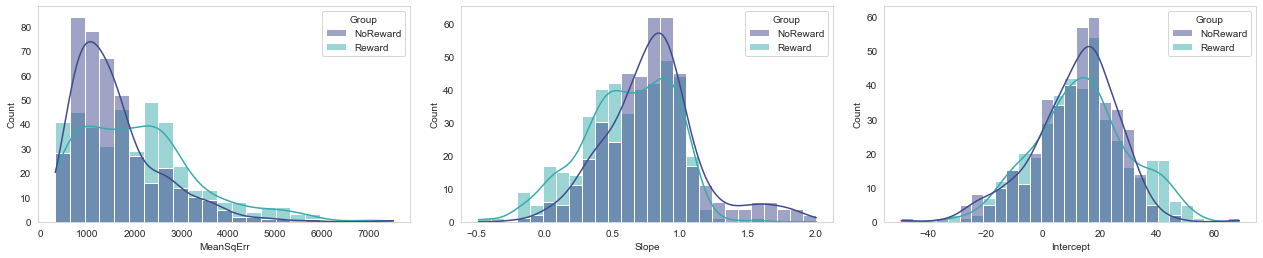

In [24]:
plt.figure()
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.tight_layout(pad=2)
sns.histplot(data=df_metrics[outlier_mask], x="MeanSqErr", palette=allPalettes, hue="Group", kde=True)
plt.grid(False)

plt.subplot(132)
plt.tight_layout(pad=2)
sns.histplot(data=df_metrics[outlier_mask], x="Slope", palette=allPalettes, hue="Group", kde=True)
plt.grid(False)

plt.subplot(133)
plt.tight_layout(pad=2)
sns.histplot(data=df_metrics[outlier_mask], x="Intercept", palette=allPalettes, hue="Group", kde=True)
plt.grid(False)

plt.savefig(path2figure + str(np.round(time.time())) +"_Sub_Normal" + "_.png", dpi = 600, bbox_inches='tight')

### Linear Mixed Effects Model 

In [25]:
md = smf.mixedlm("MeanSqErr ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- MSE: -------------------\n', mdf.summary(), '\n \n')



md = smf.mixedlm("Slope ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- Slope: -------------------\n', mdf.summary(), '\n \n')



md = smf.mixedlm("Intercept ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- Intercept: -------------------\n', mdf.summary(), '\n \n')

C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/110727455.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("MeanSqErr ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/110727455.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("Slope ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])


------------------- MSE: -------------------
                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      MeanSqErr  
No. Observations:      830          Method:                  REML       
No. Groups:            36           Scale:                   882068.6340
Min. group size:       1            Log-Likelihood:          -6884.0428 
Max. group size:       53           Converged:               Yes        
Mean group size:       23.1                                             
------------------------------------------------------------------------
                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------
Intercept               1558.659  243.053  6.413 0.000 1082.283 2035.034
Group[T.Reward]         1050.199  322.581  3.256 0.001  417.953 1682.446
Trial                     -0.026    3.217 -0.008 0.993   -6.332    6.279
Trial:Group[T.Reward]  

C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/110727455.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("Intercept ~ (Trial * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])


### LME stats with phases 

# Within phase analysis 

> simplest approach --> Visual analysis with end of adaptation most difference (t-test reward vs no reward) 
> Across the three different phases are there differences between the two groups? 
> Within dial data 

In [26]:
md = smf.mixedlm("MeanSqErr ~ (Phase * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- MSE: -------------------\n', mdf.summary(), '\n \n')


md = smf.mixedlm("Slope ~ (Phase  * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- Slope: -------------------\n', mdf.summary(), '\n \n')


md = smf.mixedlm("Intercept ~ (Phase * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
mdf = md.fit()
print('------------------- Intercept: -------------------\n', mdf.summary(), '\n \n')

C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/180277190.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("MeanSqErr ~ (Phase * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/180277190.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("Slope ~ (Phase  * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])


------------------- MSE: -------------------
                         Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          MeanSqErr  
No. Observations:           830              Method:                      REML       
No. Groups:                 36               Scale:                       851540.4977
Min. group size:            1                Log-Likelihood:              -6851.9665 
Max. group size:            53               Converged:                   Yes        
Mean group size:            23.1                                                     
-------------------------------------------------------------------------------------
                                    Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------
Intercept                           1574.627  257.900  6.106 0.000  1069.153 2080.101
Phase[T.Baseline]               

C:\Users\obipc\AppData\Local\Temp/ipykernel_8900/180277190.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md = smf.mixedlm("Intercept ~ (Phase * Group)", data = df_metrics[outlier_mask], groups=df_metrics[outlier_mask]["PtxID"])
